In [1]:
## Used Code From https://www.kaggle.com/code/timgoodfellow/nsl-kdd-explorations to get NSL-KDD setup

In [2]:
import ipyparallel as ipp
n = 4
rc = ipp.Cluster(engines="mpi", n=n).start_and_connect_sync()
view = rc[:]
rc.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

In [3]:
%%px --block
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpi4py import MPI
import copy
np.random.seed(482)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank, mpi.size))

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] MPI rank: 0/4


[stdout:1] MPI rank: 1/4


[stdout:3] MPI rank: 3/4


[stdout:2] MPI rank: 2/4


## Helper Functions

In [4]:
%%px --block
# Implement Custom Loss Function
@tf.function
def consensus_loss(y_true, y_pred, z, l2):
    
    # local error
    local_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    # consensus error
    consensus_loss = tf.keras.losses.CategoricalCrossentropy()(z, y_pred)
        
    return local_loss + consensus_loss

In [5]:
 %%px --block
# Play around with this more
def set_learning_rate1(optimizer, epoch):
    if epoch <= 30:
        optimizer.lr = 0.0025
    if 30 < epoch <= 100:
        optimizer.lr = 0.0015
    elif 100 < epoch <= 200:
        optimizer.lr = 0.001
    elif 200 < epoch <= 300:
        optimizer.lr = 0.0005
    elif 300 < epoch <= 400:
        optimizer.lr = 0.00045
    elif 400 < epoch <= 450:
        optimizer.lr = 0.00005
    else:
        optimizer.lr = 0.00001

In [6]:
 %%px --block
# Play around with this more
def set_learning_rate2(optimizer, epoch):
    if epoch >= 1:
        optimizer.lr = optimizer.lr * tf.math.exp(-0.1)

In [7]:
%%px --block
def average_models(model, local_update, layer_shapes, layer_sizes):
    model_weights = model.get_weights()
    # flatten tensor weights
    coordinate_weights = flatten_weights(model_weights)
    local_weights = flatten_weights(local_update)
    next_weights = unflatten_weights(np.average([coordinate_weights, local_weights], axis=0),
                                           layer_shapes, layer_sizes)
    # update model weights to average
    model.set_weights(next_weights)

In [8]:
%%px --block
def get_model_architecture(model):
    # find shape and total elements for each layer of the resnet model
    model_weights = model.get_weights()
    layer_shapes = []
    layer_sizes = []
    for i in range(len(model_weights)):
        layer_shapes.append(model_weights[i].shape)
        layer_sizes.append(model_weights[i].size)
    return layer_shapes, layer_sizes

In [9]:
%%px --block
def flatten_weights(weight_list):
    return np.concatenate(list(weight_list[i].flatten() for i in range(len(weight_list))))

In [10]:
%%px --block
def unflatten_weights(flat_weights, layer_shapes, layer_sizes):
    unflatten_model = []
    start_idx = 0
    end_idx = 0
    for i in range(len(layer_shapes)):
        layer_size = layer_sizes[i]
        end_idx += layer_size
        unflatten_model.append(flat_weights[start_idx:end_idx].reshape(layer_shapes[i]))
        start_idx += layer_size
    return unflatten_model

In [11]:
%%px --block

def data_pre_process(rank, size, train_pct, train_bs, test_bs, coordination_size, coord_bs):

    # read in CSV data
    raw_df_data = pd.read_csv("Data/Darknet.CSV", parse_dates=["Timestamp"], on_bad_lines='skip')

    # make timestamp numeric (just time of day)
    timestamp = raw_df_data["Timestamp"]
    raw_df_data["Timestamp"] = timestamp.dt.hour + timestamp.dt.minute/60 + timestamp.dt.second/3600

    # remove NaN rows and Inf
    raw_df = raw_df_data.replace([np.inf, -np.inf], np.nan)
    raw_df.dropna(inplace=True)

    # clean up the sub-labels (incorrectly labeled)
    raw_df.loc[raw_df['Label.1']=='AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
    raw_df.loc[raw_df['Label.1']=='AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
    raw_df.loc[raw_df['Label.1']=='Video-streaming', 'Label.1'] = 'Video-Streaming'
    raw_df.rename(columns = {"Label.1" : "Subtype"}, inplace = True)

    # add one-hot encoding of the sub-labels
    onehot = pd.get_dummies(raw_df['Subtype'])
    raw_df = pd.concat([raw_df, onehot], axis=1, join='inner')

    # drop IP columns and 0 columns
    ip_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Active Mean', 'Active Std', 'Active Max', 
               'Active Min', 'Subflow Bwd Packets', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 
               'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'URG Flag Count', 'CWE Flag Count', 
               'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags','Bwd URG Flags']
    raw_df.drop(ip_cols, axis=1, inplace=True)

    # label dataframe
    traffic_categories = raw_df['Label'].unique()
    tc = dict(zip(traffic_categories, range(len(traffic_categories))))
    class_attack = raw_df.Label.map(lambda a: tc[a])
    raw_df['Label'] = class_attack

    # shuffle dataset
    raw_df = raw_df.sample(frac=1)

    # extract features
    non_normalized_df = raw_df.drop(['Label', 'Subtype'], axis=1)

    # extract labels
    labels = raw_df['Label']

    # normalize the feature dataframe
    normalized_df = non_normalized_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # create coordination set
    coord_x = tf.convert_to_tensor(normalized_df.iloc[:coordination_size,:])
    coord_y = tf.convert_to_tensor(labels[:coordination_size])
    coordination_set = tf.data.Dataset.from_tensor_slices((coord_x,coord_y)).batch(coord_bs)

    # get data info
    num_inputs = len(normalized_df.columns.to_list())
    num_outputs = len(traffic_categories)
    
    # Split training data amongst workers
    worker_data = np.array_split(normalized_df.iloc[coordination_size:,:], size)[rank]
    worker_label = np.array_split(labels[coordination_size:], size)[rank]
    
    # create train/test split
    num_data = len(worker_label)
    num_train =  int(num_data * train_pct)
    # train
    train_x = tf.convert_to_tensor(worker_data.iloc[:num_train,:])
    train_y = tf.convert_to_tensor(worker_label[:num_train])
    train_set = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(train_bs)
    # test
    test_x = tf.convert_to_tensor(worker_data.iloc[num_train:,:])
    test_y = tf.convert_to_tensor(worker_label[num_train:])
    test_set = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(test_bs)
    
    # full training set
    full_train_data = tf.convert_to_tensor(normalized_df)
    full_train_label = tf.convert_to_tensor(labels)
    
    return train_set, test_set, coordination_set, full_train_data, full_train_label, num_inputs, num_outputs

In [12]:
%%px --block
def train(model, rank, size, lossF, optimizer, train_dataset, coordination_dataset, epochs, 
          coord_batch_size, batches, num_outputs, layer_shapes, layer_sizes, l2):

    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
        
    for epoch in range(epochs):
        
        # Adjust learning rate
        set_learning_rate2(optimizer, epoch)

        # Forward Pass of Coordination Set (get z)
        send_predicted = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
        recv_avg_pred = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
        for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
            pred = model(c_data, training=True)
            send_predicted[:, c_batch_idx] = pred.numpy().flatten()

        # Communication Process Here
        MPI.COMM_WORLD.Allreduce(send_predicted, recv_avg_pred, op=MPI.SUM)
        recv_avg_pred = recv_avg_pred/size

        # save initial model
        start_model = copy.deepcopy(model.get_weights())

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)

        # save model after local update
        local_model = copy.deepcopy(model.get_weights())

        # reset model weights
        model.set_weights(start_model)
        
        # Consensus Training
        for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
            with tf.GradientTape() as tape:
                c_yp = model(c_data, training=True)
                loss_val = consensus_loss(y_true=c_target, y_pred=c_yp,
                                           z=recv_avg_pred[:, c_batch_idx].reshape(coord_batch_size, num_outputs),
                                           l2=l2)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # update model weights
        average_models(model, local_model, layer_shapes, layer_sizes)
        
        print('(Rank %d) Epoch %d: Training Accuracy is %0.4f, Loss is %0.4f' % (rank, epoch, acc_metric.result(), \
                                                                                loss_metric.result()))
        loss_metric.reset_states()
        acc_metric.reset_states()

## Run Experiments

In [19]:
%%px --block
train_pct = 0.8
train_bs = 64
test_bs = 64
coord_bs = 32
coordination_size = coord_bs**2
coord_num_batches = int(np.ceil(coordination_size/coord_bs))

train_set, test_set, coord_set, full_train_x, full_train_y, num_inputs, num_outputs = data_pre_process(rank, size, train_pct, 
                                                                                                       train_bs, test_bs,
                                                                                                       coordination_size, 
                                                                                                       coord_bs)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [20]:
%%px --block
# multi classification model
if rank == 0 or rank == 1:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))
else:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))

# Initialize Local Loss Function
lossF = tf.keras.losses.SparseCategoricalCrossentropy()

# model architecture
layer_shapes, layer_sizes = get_model_architecture(multi_model)

# l2 penalty
l2 = 0.1

# epochs
epochs = 10

# Initialize Optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [28]:
%%px --block
train(multi_model, rank, size, lossF, optimizer, train_set, 
      coord_set, epochs, coord_bs, coord_num_batches, num_outputs, layer_shapes, layer_sizes, l2)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:1] (Rank 1) Epoch 0: Training Accuracy is 0.9948, Loss is 0.0128
(Rank 1) Epoch 1: Training Accuracy is 0.9949, Loss is 0.0125
(Rank 1) Epoch 2: Training Accuracy is 0.9949, Loss is 0.0123
(Rank 1) Epoch 3: Training Accuracy is 0.9950, Loss is 0.0121
(Rank 1) Epoch 4: Training Accuracy is 0.9952, Loss is 0.0119
(Rank 1) Epoch 5: Training Accuracy is 0.9951, Loss is 0.0117
(Rank 1) Epoch 6: Training Accuracy is 0.9952, Loss is 0.0115
(Rank 1) Epoch 7: Training Accuracy is 0.9951, Loss is 0.0114
(Rank 1) Epoch 8: Training Accuracy is 0.9952, Loss is 0.0112
(Rank 1) Epoch 9: Training Accuracy is 0.9953, Loss is 0.0111


[stdout:0] (Rank 0) Epoch 0: Training Accuracy is 0.9949, Loss is 0.0129
(Rank 0) Epoch 1: Training Accuracy is 0.9951, Loss is 0.0125
(Rank 0) Epoch 2: Training Accuracy is 0.9951, Loss is 0.0122
(Rank 0) Epoch 3: Training Accuracy is 0.9951, Loss is 0.0120
(Rank 0) Epoch 4: Training Accuracy is 0.9952, Loss is 0.0117
(Rank 0) Epoch 5: Training Accuracy is 0.9954, Loss is 0.0115
(Rank 0) Epoch 6: Training Accuracy is 0.9955, Loss is 0.0113
(Rank 0) Epoch 7: Training Accuracy is 0.9956, Loss is 0.0110
(Rank 0) Epoch 8: Training Accuracy is 0.9957, Loss is 0.0108
(Rank 0) Epoch 9: Training Accuracy is 0.9958, Loss is 0.0106


[stdout:3] (Rank 3) Epoch 0: Training Accuracy is 0.9933, Loss is 0.0164
(Rank 3) Epoch 1: Training Accuracy is 0.9934, Loss is 0.0159
(Rank 3) Epoch 2: Training Accuracy is 0.9937, Loss is 0.0156
(Rank 3) Epoch 3: Training Accuracy is 0.9940, Loss is 0.0153
(Rank 3) Epoch 4: Training Accuracy is 0.9941, Loss is 0.0149
(Rank 3) Epoch 5: Training Accuracy is 0.9942, Loss is 0.0146
(Rank 3) Epoch 6: Training Accuracy is 0.9943, Loss is 0.0143
(Rank 3) Epoch 7: Training Accuracy is 0.9943, Loss is 0.0140
(Rank 3) Epoch 8: Training Accuracy is 0.9945, Loss is 0.0137
(Rank 3) Epoch 9: Training Accuracy is 0.9946, Loss is 0.0135


[stdout:2] (Rank 2) Epoch 0: Training Accuracy is 0.9929, Loss is 0.0169
(Rank 2) Epoch 1: Training Accuracy is 0.9931, Loss is 0.0166
(Rank 2) Epoch 2: Training Accuracy is 0.9933, Loss is 0.0161
(Rank 2) Epoch 3: Training Accuracy is 0.9935, Loss is 0.0158
(Rank 2) Epoch 4: Training Accuracy is 0.9937, Loss is 0.0156
(Rank 2) Epoch 5: Training Accuracy is 0.9937, Loss is 0.0153
(Rank 2) Epoch 6: Training Accuracy is 0.9938, Loss is 0.0151
(Rank 2) Epoch 7: Training Accuracy is 0.9939, Loss is 0.0149
(Rank 2) Epoch 8: Training Accuracy is 0.9939, Loss is 0.0147
(Rank 2) Epoch 9: Training Accuracy is 0.9940, Loss is 0.0145


In [29]:
%%px --block
predictions = multi_model.predict(full_train_x)

[stdout:0] 4422/4422 [==============================] - 6s 1ms/step


[stdout:1] 4422/4422 [==============================] - 6s 1ms/step


[stdout:3] 4422/4422 [==============================] - 6s 1ms/step


[stdout:2] 4422/4422 [==============================] - 6s 1ms/step


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [30]:
%%px --block
pred = tf.math.argmax(predictions, axis=1)
train_confusion_mtx = tf.math.confusion_matrix(full_train_y, pred)
# normalize confusion matrix
train_confusion_mtx = train_confusion_mtx / tf.reduce_sum(train_confusion_mtx, 0).numpy()
train_confusion_mtx = tf.where(tf.math.is_nan(train_confusion_mtx), tf.zeros_like(train_confusion_mtx), train_confusion_mtx)

[output:1]

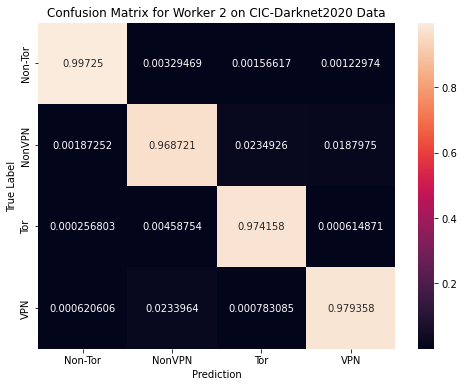

[output:2]

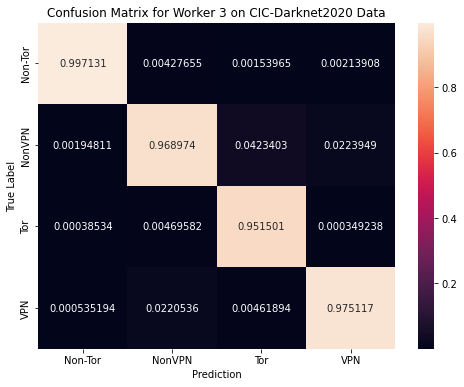

[output:0]

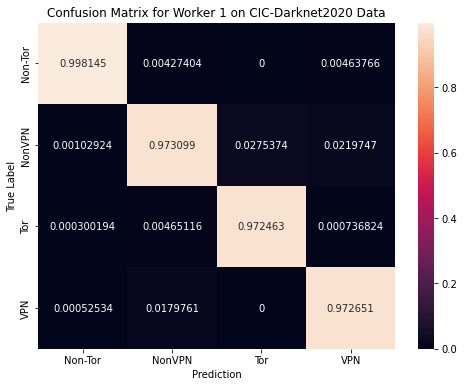

[output:3]

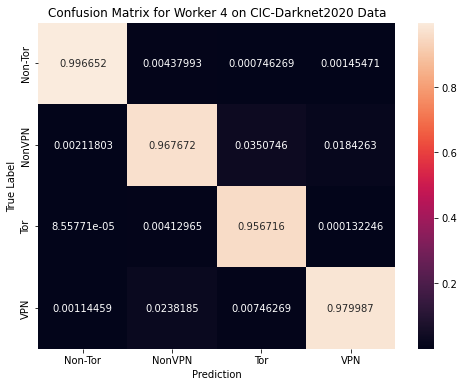

In [31]:
%%px --block
attack_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion_mtx,
            xticklabels=attack_labels,
            yticklabels=attack_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Worker %d on CIC-Darknet2020 Data' % (rank+1))
plt.show()